In [9]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# ==========================================================
# 📦 1️⃣ SETUP & LOAD DATASET (with train/validation split)
# ==========================================================

# Step 1: Import required libraries
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ----------------------------------------------------------
# Step 2: Define dataset directories
# ----------------------------------------------------------
# You should have already extracted your dataset ZIP into 'skin_data/'.
# Inside it, there should be:
# skin_data/
# ├── train/
# │   ├── Benign/
# │   └── Malignant/
# └── test/
#     ├── Benign/
#     └── Malignant/

TRAIN_DIR = "train"
TEST_DIR = "test"

# Verify that directories exist
print("TRAIN_DIR exists:", os.path.exists(TRAIN_DIR))
print("Contents of TRAIN_DIR:", os.listdir(TRAIN_DIR))
print("TEST_DIR exists:", os.path.exists(TEST_DIR))
print("Contents of TEST_DIR:", os.listdir(TEST_DIR))

# ----------------------------------------------------------
# Step 3: Define image preprocessing parameters
# ----------------------------------------------------------
IMG_SIZE = (224, 224)   # Resize all images to 224x224
BATCH_SIZE = 32         # Number of images per batch

# ----------------------------------------------------------
# Step 4: Create ImageDataGenerators (with validation split)
# ----------------------------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=20,       # Randomly rotate images
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Horizontal flip
    validation_split=0.2     # <-- 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization

# ----------------------------------------------------------
# Step 5: Create training & validation generators
# ----------------------------------------------------------
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",    # Training subset
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",  # Validation subset
    shuffle=False
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# ----------------------------------------------------------
# Step 6: Display class mapping
# ----------------------------------------------------------
print("Class Mapping:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)
print("Number of test samples:", test_generator.samples)


TRAIN_DIR exists: True
Contents of TRAIN_DIR: ['Benign', 'Malignant']
TEST_DIR exists: True
Contents of TEST_DIR: ['Benign', 'Malignant']
Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}
Number of training samples: 9504
Number of validation samples: 2375
Number of test samples: 2000



--- RAW IMAGES (Benign) ---
Image: 1.jpg
 Shape: (224, 224, 3)
 Pixel range: 0 - 240
------------------------------
Image: 10.jpg
 Shape: (224, 224, 3)
 Pixel range: 43 - 255
------------------------------
Image: 100.jpg
 Shape: (224, 224, 3)
 Pixel range: 9 - 214
------------------------------
Image: 1000.jpg
 Shape: (224, 224, 3)
 Pixel range: 40 - 255
------------------------------
Image: 1001.jpg
 Shape: (224, 224, 3)
 Pixel range: 37 - 231
------------------------------


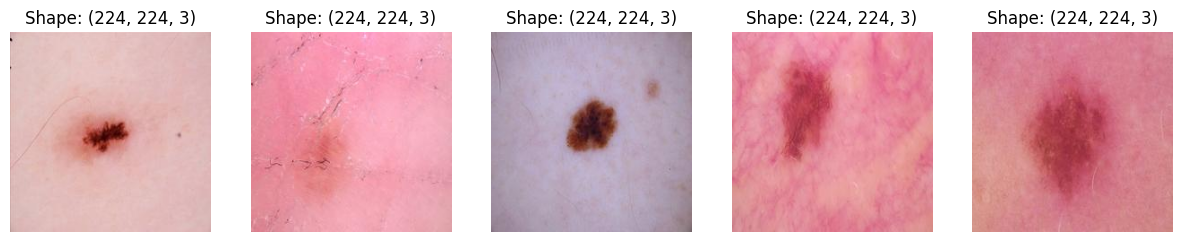


--- RAW IMAGES (Malignant) ---
Image: 1.jpg
 Shape: (224, 224, 3)
 Pixel range: 0 - 255
------------------------------
Image: 10.jpg
 Shape: (224, 224, 3)
 Pixel range: 0 - 234
------------------------------
Image: 100.jpg
 Shape: (224, 224, 3)
 Pixel range: 9 - 255
------------------------------
Image: 1000.jpg
 Shape: (224, 224, 3)
 Pixel range: 56 - 248
------------------------------
Image: 1001.jpg
 Shape: (224, 224, 3)
 Pixel range: 0 - 205
------------------------------


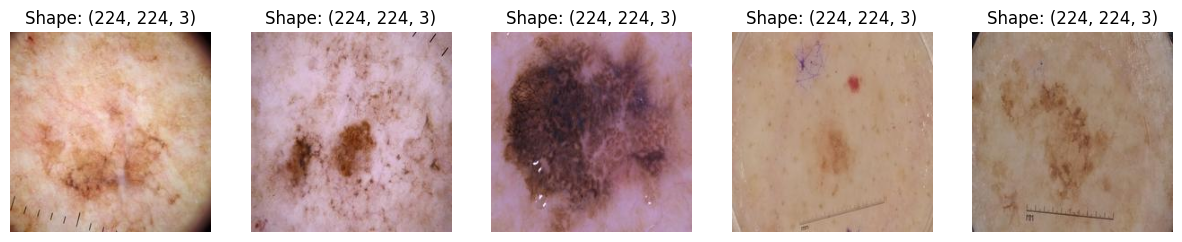

Found 11879 images belonging to 2 classes.

--- PREPROCESSED TRAIN IMAGES ---
Image 1
 Shape: (224, 224, 3)
 Pixel range: 0.4716 - 1.0000
 Label: 0
------------------------------
Image 2
 Shape: (224, 224, 3)
 Pixel range: 0.1870 - 1.0000
 Label: 0
------------------------------
Image 3
 Shape: (224, 224, 3)
 Pixel range: 0.0027 - 0.8072
 Label: 1
------------------------------
Image 4
 Shape: (224, 224, 3)
 Pixel range: 0.0000 - 0.8320
 Label: 1
------------------------------
Image 5
 Shape: (224, 224, 3)
 Pixel range: 0.0000 - 1.0000
 Label: 1
------------------------------
Image 6
 Shape: (224, 224, 3)
 Pixel range: 0.1095 - 0.9896
 Label: 0
------------------------------
Image 7
 Shape: (224, 224, 3)
 Pixel range: 0.0321 - 0.8098
 Label: 1
------------------------------
Image 8
 Shape: (224, 224, 3)
 Pixel range: 0.0628 - 0.6966
 Label: 1
------------------------------
Image 9
 Shape: (224, 224, 3)
 Pixel range: 0.0000 - 0.9855
 Label: 1
------------------------------
Image 10
 Sha

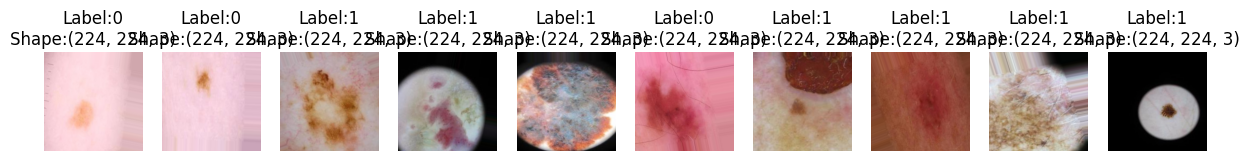

In [5]:
# =============================================
# 📊 Visualize RAW vs PREPROCESSED Train Images
# =============================================

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------------
# 1️⃣ Show RAW images from the train folder
# -----------------------------
def show_raw_images_and_properties(directory, class_name, num_images=5):
    """
    Displays a few raw images (without preprocessing)
    along with their shape and pixel range.
    """
    class_path = os.path.join(directory, class_name)
    images = os.listdir(class_path)[:num_images]  # Take first N images

    plt.figure(figsize=(15, 4))
    print(f"\n--- RAW IMAGES ({class_name}) ---")

    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        img_np = np.array(img)

        # Show image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Shape: {img_np.shape}")
        plt.axis('off')

        # Print image properties
        print(f"Image: {img_name}")
        print(f" Shape: {img_np.shape}")
        print(f" Pixel range: {img_np.min()} - {img_np.max()}")
        print("-" * 30)

    plt.show()


# ✅ Show 5 raw images from each class (Benign & Malignant)
show_raw_images_and_properties("train", 'Benign', 5)
show_raw_images_and_properties("train", 'Malignant', 5)


# -----------------------------
# 2️⃣ Show PREPROCESSED images from train_generator
# -----------------------------
# Create the ImageDataGenerator with augmentation
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,        # Normalize to [0,1]
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shearing
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True      # Flip horizontally
)

# Load training data from the "train" directory
train_generator = train_datagen.flow_from_directory(
    "train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# ✅ Get one batch of preprocessed images
images, labels = next(train_generator)

plt.figure(figsize=(15, 4))
print("\n--- PREPROCESSED TRAIN IMAGES ---")

for i in range(10):  # show first 10 images in the batch
    img = images[i]
    label = int(labels[i])

    plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.title(f"Label:{label}\nShape:{img.shape}")
    plt.axis('off')

    # Print properties of preprocessed images
    print(f"Image {i+1}")
    print(f" Shape: {img.shape}")
    print(f" Pixel range: {img.min():.4f} - {img.max():.4f}")
    print(f" Label: {label}")
    print("-" * 30)

plt.show()


#If an image comes from the Benign folder → it gets label 0

#If an image comes from the Malignant folder → it gets label 1


### MODEL BUILD ###


In [14]:
# from tensorflow.keras import layers, models

# model = models.Sequential([
#     # 1️⃣ Convolution Block 1
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D((2, 2)),

#     # 2️⃣ Convolution Block 2
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     # 3️⃣ Convolution Block 3
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     # 4️⃣ Flattening Layer
#     layers.Flatten(),

#     # 5️⃣ Fully Connected (Dense) Layers
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),  # Helps reduce overfitting
#     layers.Dense(1, activation='sigmoid')  # Output layer (binary classification)
# ])
import tensorflow as tf

from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),   # ✅ specify input here
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') # Output layer (binary classification)
])

# NOT RUN THIS 
model.compile(
    # optimizer='adam',                # Adaptive optimizer for faster learning
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',      # Because we have 2 classes (0 & 1)
    metrics=['accuracy']             # Track accuracy during training
)

model.summary()
model = build_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'build_model' is not defined

### MODEL TRAIN ###

Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 717s 2s/step - accuracy: 0.7734 - loss: 0.4870 - val_accuracy: 0.8150 - val_loss: 0.3731 - learning_rate: 0.0010
Epoch 2/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.8750 - loss: 0.2915 - val_accuracy: 0.7253 - val_loss: 0.5558 - learning_rate: 0.0010
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 644s 2s/step - accuracy: 0.8151 - loss: 0.4186 - val_accuracy: 0.7369 - val_loss: 0.5385 - learning_rate: 0.0010
Epoch 4/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 10:20 2s/step - accuracy: 0.9688 - loss: 0.1526
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
371/371 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9688 - loss: 0.1526 - val_accuracy: 0.7757 - val_loss: 0.4834 - learning_rate: 0.0010
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.8452 - loss: 0.3529 - val_accuracy: 0.8679 - val_loss: 0.3262 - learning_rate: 3.0000e-04
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9062 - l

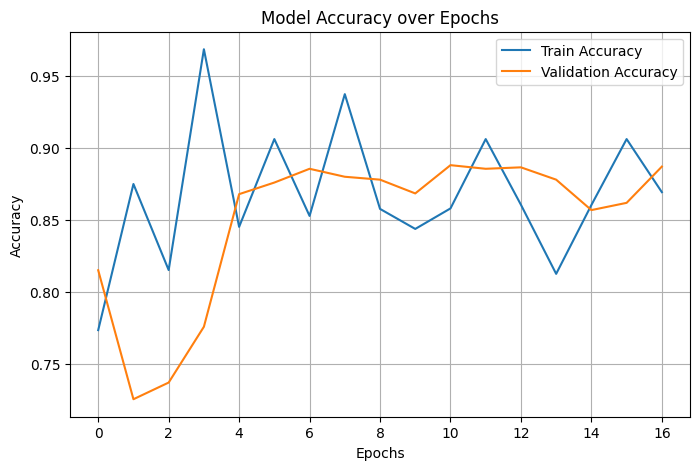

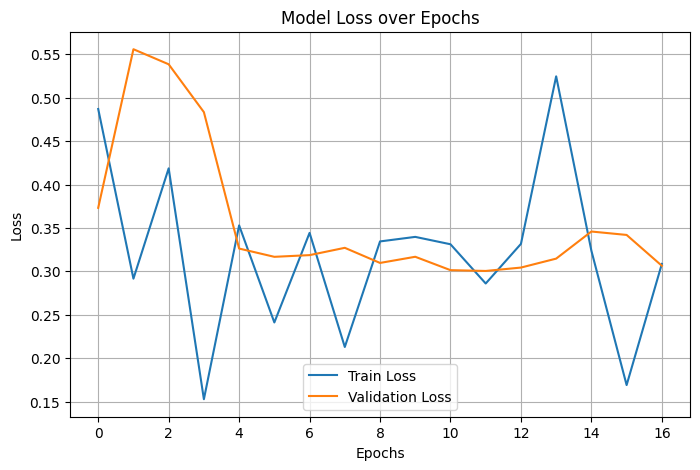

In [23]:
# ✅ Train & Evaluate Model in Jupyter Notebook

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# EarlyStopping to stop training when the model stops improving
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,  # Stop training after 5 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau to reduce the learning rate if the model stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,  # Reduce LR if no improvement after 3 epochs
    min_lr=1e-7,
    verbose=1
)

# ✅ Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# ✅ Save final trained model (no checkpoints)
model.save("skin_cancer_cnn_final.h5")

# ✅ Plot training history
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### MODEL FINE TUNING ###


✅ Loaded pre-trained model successfully!
✅ Model recompiled with smaller learning rate (1e-5).
Epoch 16/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8631 - loss: 0.3234
Epoch 16: val_accuracy improved from None to 0.88400, saving model to skin_cancer_cnn_finetuned.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 884s 2s/step - accuracy: 0.8669 - loss: 0.3172 - val_accuracy: 0.8840 - val_loss: 0.3035 - learning_rate: 1.0000e-05
Epoch 17/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8651 - loss: 0.3159
Epoch 17: val_accuracy improved from 0.88400 to 0.89350, saving model to skin_cancer_cnn_finetuned.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 724s 2s/step - accuracy: 0.8707 - loss: 0.3082 - val_accuracy: 0.8935 - val_loss: 0.2973 - learning_rate: 1.0000e-05
Epoch 18/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8681 - loss: 0.3104
Epoch 18: val_accuracy improved from 0.89350 to 0.89600, saving model to skin_cancer_cnn_finetuned.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 723s 2s/step -

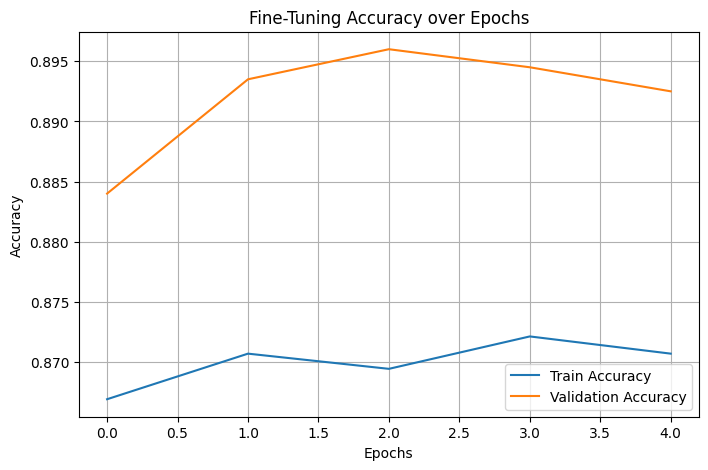

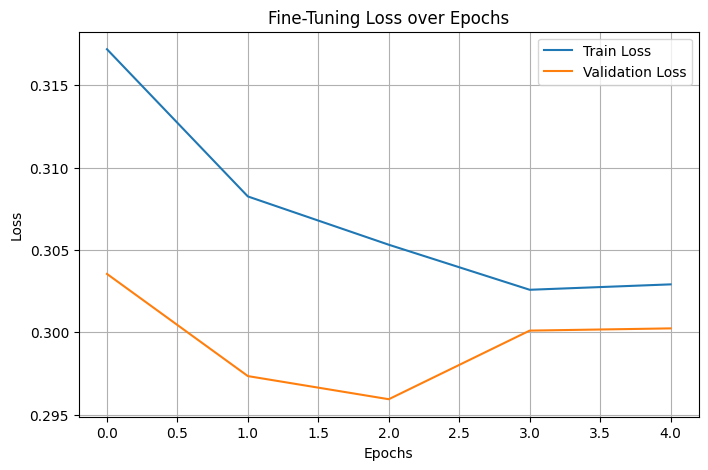

In [7]:
# ==============================================
# 🔁 Continue Training (Fine-tuning) CNN Model
# ==============================================
# ==============================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# 1️⃣ Load the previously trained model
model = load_model("skin_cancer_cnn_final.h5")
print("✅ Loaded pre-trained model successfully!")

# 2️⃣ Optional: Unfreeze deeper layers (only for transfer-learning models)
# If you used a base model like VGG16, ResNet, MobileNet, etc.
# Example:
# for layer in model.layers[-10:]:   # Unfreeze last 10 layers
#     layer.trainable = True

# 3️⃣ Recompile the model with a smaller learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),   # small LR = fine-grained learning
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("✅ Model recompiled with smaller learning rate (1e-5).")

# 4️⃣ Set up callbacks again
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "skin_cancer_cnn_finetuned.keras",    # use native Keras format
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# 5️⃣ Continue training (fine-tuning)
history_finetune = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,                 # target total epochs (model already trained 17)
    initial_epoch=15,          # resume from 17 → run up to 30
    validation_data=test_generator,
    # validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

# 6️⃣ Save final fine-tuned model
model.save("skin_cancer_cnn_finetuned.keras")
print("✅ Fine-tuned model saved successfully!")

# 7️⃣ Plot fine-tuning accuracy & loss
plt.figure(figsize=(8,5))
plt.plot(history_finetune.history["accuracy"], label="Train Accuracy")
plt.plot(history_finetune.history["val_accuracy"], label="Validation Accuracy")
plt.title("Fine-Tuning Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_finetune.history["loss"], label="Train Loss")
plt.plot(history_finetune.history["val_loss"], label="Validation Loss")
plt.title("Fine-Tuning Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### PREDICT ON TEST SET ###

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_prob = model.predict(test_generator, verbose=1)

# Convert probabilities → binary (0/1)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# True labels
y_true = test_generator.classes[:len(y_pred)]


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step


In [ ]:
### Classification Report (Precision, Recall, F1) ###

In [10]:
print("🔍 Classification Report")
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


🔍 Classification Report
              precision    recall  f1-score   support

      Benign       0.88      0.92      0.90      1000
   Malignant       0.91      0.87      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [ ]:
### Confusion Matrix ###

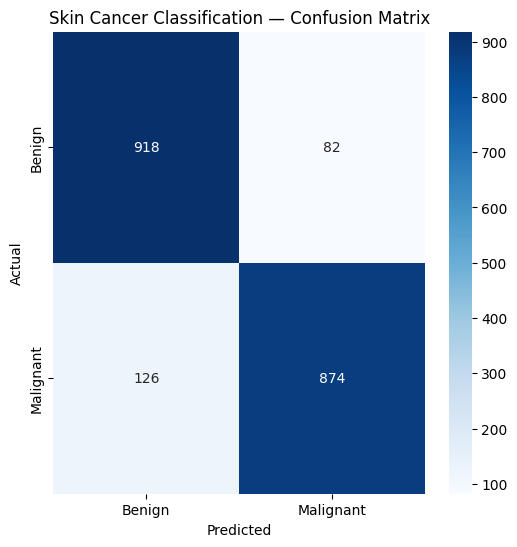

In [11]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Skin Cancer Classification — Confusion Matrix")
plt.show()


In [ ]:
### Calculate Accuracy & F1-Score manually ###

In [12]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Model Accuracy: {acc*100:.2f}%")
print(f"F1-Score: {f1:.4f}")


Model Accuracy: 89.60%
F1-Score: 0.8937


In [ ]:
### AUC - ROC CURVE ###

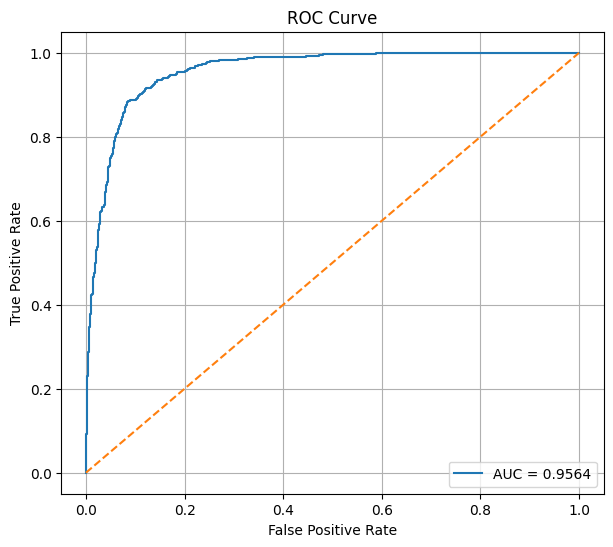

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
from tensorflow.keras.models import load_model

# Load original model
original_model = load_model("skin_cancer_cnn_final.h5")
loss1, acc1 = original_model.evaluate(test_generator, verbose=0)

# Load fine-tuned model
finetuned_model = load_model("skin_cancer_cnn_finetuned.keras")
loss2, acc2 = finetuned_model.evaluate(test_generator, verbose=0)

# Print results
print(f"✅ Original model accuracy: {acc1*100:.2f}%")
print(f"✅ Fine-tuned model accuracy: {acc2*100:.2f}%")


✅ Original model accuracy: 88.50%
✅ Fine-tuned model accuracy: 89.60%
